In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import imageio
from PIL import Image
import json
from scipy.spatial import Delaunay
import skimage as ski
import einops

def read_img(img_name, img_dir = 'in_dir/', grayscale=False):
    if '.' not in img_name:
        img_name += '.jpg'
    img = Image.open(img_dir + '/' + img_name)
    if grayscale:
        img = img.convert('L')
    img = np.array(img)
    img = img / 255
    return img
images_out = 'images_out/' 
def save_img(fname, img_out, out_dir = images_out, grayscale=False):
    if '.jpg' not in fname:
        fname = fname + '.jpg'
    full_name = out_dir + '/' + fname
    img_out = np.clip(img_out, a_min=0, a_max=1)
    # img_out = (img_out*255).astype(np.uint8)
    if grayscale:
        imageio.imwrite(full_name, img_out)
    else:
        plt.imsave(full_name, img_out)

In [412]:
# Computes the homography p’=Hp, where H
# is a 3x3 matrix with 8 degrees of freedom
def compute_h(img_1_pts, img_2_pts):
    assert len(img_1_pts) == len(img_2_pts)
    n = len(img_1_pts)
    img_1_pts = np.asarray(img_1_pts)
    img_1_hom = to_homogenous(img_1_pts)
    img_2_pts = np.asarray(img_2_pts)
    img_2_pts_flat = np.ndarray.flatten(img_2_pts)
    
    len_H = 9
    A = np.zeros((2*n, len_H))
    A[:, -1] = 1 # Set 1's
    A[1::2, 5] = -1 # Set -1's
    A[0::2, 2] = -1 # Set -1's

    A[0:-1:2, :2] = -img_1_pts # Set first 2 columns with -p
    A[1::2, 3:5] = -img_1_pts # Set columns 3&4 with img1 -p

    # Set end columns with p
    A[::2, -3:-1] = img_1_pts 
    A[1::2, -3:-1] = img_1_pts 

    # Multiply end columns with p'
    A[:, -3] *= img_2_pts_flat
    A[:, -2] *= img_2_pts_flat
    A[:, -1] *= img_2_pts_flat
    b = -A[:, -1]
    A_cr = A[:, :-1]
    x, res, rank, _ = np.linalg.lstsq(A_cr, b, rcond=None)
    H = np.ones(9)
    H[:8] = x
    H = np.reshape(H, (3,3))
    return H, res, rank
# Adds ones on axis 1
def to_homogenous(inp):
    inp = np.asarray(inp)
    ones = np.ones((inp.shape[0],1))
    return np.concatenate((inp, ones), axis=1).T

# Takes homogenous points and returns normal
def homogenous_to_non(inp):
    inp = np.asarray(inp)
    z = inp[-1, :]
    inp = inp[:-1, :] / z
    return inp.T

# Applies homography to non-homogenous coordinate inp, returning the new coords
# also in non-homogenous form
def apply_h(h, inp):
    homo = to_homogenous(inp)
    transformed = h @ homo
    return homogenous_to_non(transformed)

def get_corners(img):
    img_corners = [[img.shape[1], img.shape[0]], [img.shape[1], 0], [0,0], [0, img.shape[0]]]
    return img_corners

def get_inv(A):
    return np.linalg.inv(A)

# Takes in non-homogenous points
def create_polygon(points):
    points = np.asarray(points)
    cc, rr = ski.draw.polygon(points[:,0], points[:,1], shape=None)
    return cc,rr

In [378]:
### Tests to confirm homography calculated correctly
img_1_pts = [[6,1], [2,4], [3,7], [5,4]]
img_1_pts = np.asarray(img_1_pts)
img_1_hom = to_homogenous(img_1_pts)
ans = compute_h(img_1_pts, img_1_pts)
H = ans[0]
after_H = H @ img_1_hom
assert np.all(np.isclose(img_1_hom, after_H))

H = [[10,4,6],
     [2.3,4.3,-4],
     [0, 0, 1]]
img_2_hom = H @ img_1_hom
img_2_normal = homogenous_to_non(img_2_hom)
ans = compute_h(img_1_pts, img_2_normal)
H_computed = ans[0]
assert np.all(np.isclose(H, H_computed))

In [437]:
img_dir = 'images_in/'

corr_file = img_dir + 'macbook.json'
f = open(corr_file)
correspondences = json.load(f)
img_1_points = np.array(correspondences['im1Points'])
img.shape

(3024, 4032, 3)

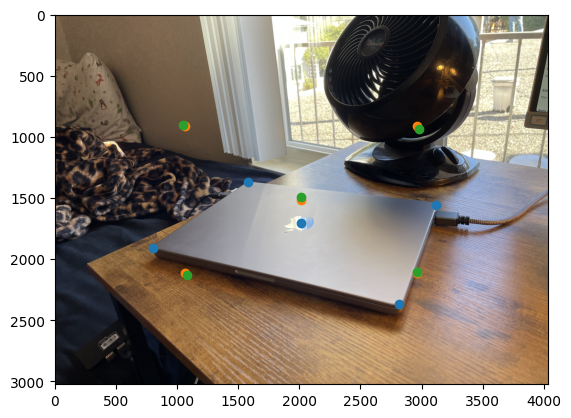

In [438]:
img = read_img('macbook', img_dir)
w, h = 950, 600
x, y = 2016, 1512
img_2_points = [[x+w,y+h], [x+w,y-h], [x-w,y-h], [x-w,y+h], [x,y]]
# img_2_points = get_corners(img)
img_2_points = np.asarray(img_2_points)
plt.scatter(img_1_points[:, 0], img_1_points[:, 1])
plt.scatter(img_2_points[:, 0], img_2_points[:, 1])
H, res, rank = compute_h(img_1_points, img_2_points)
res = apply_h(H, img_1_points)
plt.scatter(res[:,0], res[:,1])
plt.imshow(img)

In [439]:
# Flatten img to use for interpolation
X, Y = np.mgrid[:img.shape[0], :img.shape[1]]
points = np.dstack((X.ravel(), Y.ravel())).squeeze()
flat_img = einops.rearrange(img, ('h w c -> (h w) c'))
color_interp = scipy.interpolate.NearestNDInterpolator(points, flat_img)

In [466]:
new_image = np.zeros(img.shape)
cc, rr = create_polygon(get_corners(img))
src_coords = np.array([cc, rr, np.ones_like(rr)])

new = homogenous_to_non(get_inv(H) @ src_coords)   # Apply transformation to get pts in original image
c_n, r_n = new[:, 0], new[:, 1]
rr = np.clip(rr, 0, new_image.shape[0]-1)
cc = np.clip(cc, 0, new_image.shape[1]-1)
# c_n = np.clip(c_n, 0, new_image.shape[0]-1)
# r_n = np.clip(r_n, 0, new_image.shape[1]-1)

In [480]:
# Interpolate at to get the colors of the points when inv mapped
mask_c = c_n < img.shape[1]
mask_c *= c_n >= 0
mask_c = np.repeat(mask_c[:, np.newaxis], 3, axis=1)

mask_r = r_n < img.shape[0]
mask_r *= r_n >= 0
mask_r = np.repeat(mask_r[:, np.newaxis], 3, axis=1)
# mask = mask_r * mask_c

tri_interp = color_interp((r_n, c_n))
tri_interp_mask_c = np.where(mask_c, tri_interp, np.ones(3))
tri_interp_mask_rc = np.where(mask_r, tri_interp_mask_c, np.ones(3))

# tri_interp *= mask
new_image[rr, cc] = tri_interp

# for (i, tri) in enumerate(mean_tri.simplices):
#     # Gets all points within mean triangle
#     tri_points = np.array(list(map(lambda x: weighted_shape_pts[x], tri)))
#     cc, rr = ski.draw.polygon(tri_points[:,0], tri_points[:,1], shape=None)
    
#     src_tri_coords = np.array([cc, rr, np.ones_like(rr)])   # Create homogeneous coordinates
#     new =  mean_to_img_transforms[i] @ src_tri_coords     # Apply transformation to get tri in original image
#     c_n, r_n = new[0], new[1]
#     rr = np.clip(rr, 0, img.shape[0]-1)
#     cc = np.clip(cc, 0, img.shape[1]-1)
#     # Interpolate at to get the colors of the points when inv mapped
#     tri_interp = color_interp((r_n, c_n))
#     new_image[rr, cc] = tri_interp

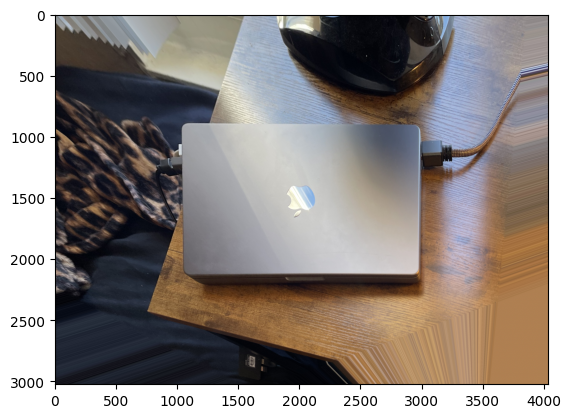

In [477]:
plt.imshow(new_image)

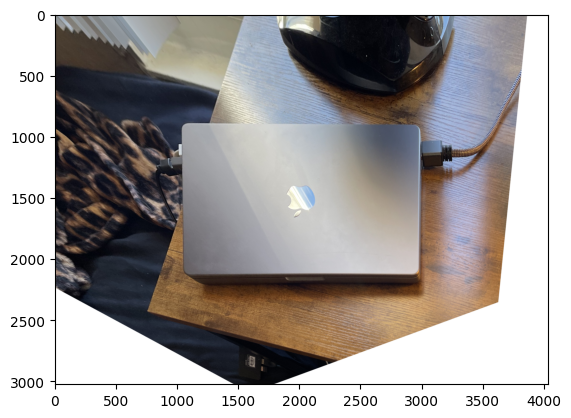

In [481]:
new_image[rr, cc] = tri_interp_mask_rc
plt.imshow(new_image)

In [458]:
H @ to_homogenous(img_corners)
# apply_h(H, img_corners)

array([[-2.08063659e+04,  2.91744593e+03, -3.46171109e+04,
         1.67281909e+04],
       [-3.33242442e+04,  1.33600198e+04, -3.12268244e+04,
         1.12625999e+04],
       [-9.88326792e+00,  1.98047264e-01, -1.06852207e+01,
         1.00000000e+00]])

In [459]:
img_corners = [[img.shape[0], img.shape[1]], [img.shape[0], 0], [0,0], [0, img.shape[1]]]
corners_transformed = apply_h(H, img_corners)
print(corners_transformed)

[[ 3239.71886333  2922.43140016]
 [14731.05899696 67458.74442801]
 [16728.19093467 11262.59989178]
 [ 2105.21115896  3371.78395962]]


In [460]:
H

array([[-4.56704531e+00, -9.30916588e+00,  1.67281909e+04],
       [ 6.93591229e-01, -1.10582451e+01,  1.12625999e+04],
       [-2.65196011e-04, -2.69922319e-03,  1.00000000e+00]])

In [461]:
H @ to_homogenous(img_1_points)

array([[-1.81347347e+04, -1.19735580e+04, -3.26905033e+03,
        -4.70121003e+03, -8.30455440e+03],
       [-1.29141867e+04, -3.74754366e+03, -2.81205102e+03,
        -9.29202337e+03, -6.13813681e+03],
       [-6.12532157e+00, -4.01903998e+00, -3.12287431e+00,
        -4.36523908e+00, -4.12331459e+00]])

In [462]:
to_homogenous(img_1_points) 

array([[2.817e+03, 3.119e+03, 1.582e+03, 8.010e+02, 2.016e+03],
       [2.363e+03, 1.553e+03, 1.372e+03, 1.909e+03, 1.700e+03],
       [1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]])